In [1]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary


from sklearn.metrics import classification_report



import warnings
warnings.filterwarnings('ignore')

In [2]:
###------------------------------
### Plot Loss Curve using pytorch
###------------------------------
def fn_plot_torch_hist(hist_df):

    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset='test_loss')
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot

    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow


    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(),
               color = 'green',
               linestyle='-.', lw = 3)

    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()




In [3]:
 # Global Variables

RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

NOISE = 0.2
EPOCHS = 2001
ALPHA = 0.001
BATCH_SIZE = 256
TEST_SIZE = 3811 #18147 - 56*256
LR_FACTOR = 0.1
LR_PATIENCE = 10

# set the plotting parameters
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')



**LOAD DATA**

In [4]:
data_df = pd.read_csv('fifa_2019.csv')

In [5]:
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [6]:
data_df.isnull().sum()

,0
Unnamed: 0,0
ID,0
Name,0
Age,0
Photo,0
...,...
GKHandling,48
GKKicking,48
GKPositioning,48
GKReflexes,48


In [7]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18207.0,9103.000000,5256.052511,0.0,4551.5,9103.0,13654.5,18206.0
ID,18207.0,214298.338606,29965.244204,16.0,200315.5,221759.0,236529.5,246620.0
Age,18207.0,25.122206,4.669943,16.0,21.0,25.0,28.0,45.0
Overall,18207.0,66.238699,6.908930,46.0,62.0,66.0,71.0,94.0
Potential,18207.0,71.307299,6.136496,48.0,67.0,71.0,75.0,95.0
Special,18207.0,1597.809908,272.586016,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18159.0,1.113222,0.394031,1.0,1.0,1.0,1.0,5.0
Weak Foot,18159.0,2.947299,0.660456,1.0,3.0,3.0,3.0,5.0
Skill Moves,18159.0,2.361308,0.756164,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [8]:
data_df= data_df[data_df['Position'].notnull()]
data_df.head()


,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [9]:
for col in data_df.columns:
  unq = data_df[col].unique()
  print(f'{col}: {len(unq)}, Values: {unq}')


Unnamed: 0: 18147, Values: [    0     1     2 ... 18204 18205 18206]
ID: 18147, Values: [158023  20801 190871 ... 241638 246268 246269]
Name: 17140, Values: ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age: 29, Values: [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo: 18147, Values: ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality: 164, Values: ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece'

In [10]:
data_df['Position'].isnull().sum()

0

In [11]:
data_df['Positioning'].value_counts()

,count
Positioning,
58.0,574
65.0,537
62.0,516
64.0,509
60.0,503
...,...
90.0,4
91.0,3
93.0,2


In [12]:
#Following columns appear to be relevant for our analysis

rel_cols= ['Position','Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [13]:
data_df.isna().sum().sum()

0

In [14]:
data_df['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

In [15]:
data_df['Position'].nunique()

27

In [16]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS', 'LS', 'CF']
midfielder = ['CM', 'RCM', 'LCM', 'CDM', 'RDM', 'LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [17]:
data_df.loc[data_df['Position'] == 'GK', 'Position'] = 0
data_df.loc[data_df['Position'].isin(defender), 'Position'] = 1
data_df.loc[data_df['Position'].isin(midfielder), 'Position'] = 2
data_df.loc[data_df['Position'].isin(forward), 'Position'] = 3
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast= 'integer')

In [18]:
data_df['Position'].unique()

array([3, 0, 2, 1], dtype=int8)

In [19]:
class_labels = {0: 'Goalkeeper', 1: 'Defender', 2: 'Midfielder', 3: 'Forward'}

In [20]:
X = features_df = data_df.drop('Position', axis = 1)
y = target_df = data_df['Position'].to_numpy()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SIZE,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE)


In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((14336, 33), (3811, 33), (14336,), (3811,))

In [23]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

Custom Datasets

In [24]:
''' Define custom dataset'''
class FifaDataset(Dataset):
  def __init__(self, X, y):
    super(FifaDataset,self).__init__()
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.long)
  def __len__(self):
    return(len(self.X))
  def __getitem__(self, idx):
    return(self.X[idx], self.y[idx])

In [25]:
train_dataset = FifaDataset(X_train, y_train)
test_dataset = FifaDataset(X_test, y_test)

test_loader = DataLoader(dataset=train_dataset,
                          shuffle=True,
                          batch_size=BATCH_SIZE, )

train_loader = DataLoader(dataset=train_dataset,
                          shuffle=True,
                          batch_size=BATCH_SIZE, )

X_batch, y_batch = next(iter(train_loader))

X_batch.shape, y_batch.shape


(torch.Size([256, 33]), torch.Size([256]))

Is Environment Ok

In [26]:
torch.cuda.is_available()

False

In [27]:
torch.version.cuda

'12.1'

In [28]:
#torch.cuda.get_device_name(torch.cuda.current_device())

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [30]:
input_dim= X_train.shape[1]

class Model(nn.Module):

  #Dropout
  #BatchNorm
  def __init__(self, input_dim):
    super(Model, self).__init__()
    dor1=0.1
    #Set1
    self.layer1 = nn.Linear(input_dim,18)
    self.actv1 = nn.ReLU()
    self.do1 = nn.Dropout(dor1)
    self.bn1 = nn.BatchNorm1d(18)
    #Set 2
    self.layer2 = nn.Linear(18,4)

  def forward(self, x):
    #Set1
    x = self.layer1(x)
    x = self.bn1(x)
    x = self.actv1(x)
    x = self.do1(x)
    #Set2
    x = self.layer2(x)
    return x

model = Model (input_dim).to(device)



print(model)

Model(
  (layer1): Linear(in_features=33, out_features=18, bias=True)
  (actv1): ReLU()
  (do1): Dropout(p=0.1, inplace=False)
  (bn1): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=18, out_features=4, bias=True)
)


In [31]:
#summary(model,(1,33))

In [32]:
for param in list(model.parameters()):
  print(param.shape)

torch.Size([18, 33])
torch.Size([18])
torch.Size([18])
torch.Size([18])
torch.Size([4, 18])
torch.Size([4])


In [33]:
#Loss Function
loss_fn = nn.CrossEntropyLoss()
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode= 'min',
                                                       factor=LR_FACTOR,
                                                       patience=LR_PATIENCE,
                                                       min_lr =ALPHA-5)

# some lists to collect progress
loss = []
tloss=[]
n_epoch =[]
acc= []
tacc= []

#loop for defined epochs
for epoch in range(EPOCHS):
    model.train()  #set your model in train mode
    epoch_loss = 0
    epoch_acc = 0
    tepoch_loss = 0
    tepoch_acc = 0


    for batch_idx, (train_X, train_y) in enumerate(train_loader):
      train_X= train_X.to(device)
      train_y= train_y.to(device)
      predict_proba = model(train_X) #make predictions
      batch_loss= loss_fn(predict_proba, train_y) #calculate loss
      epoch_loss +=(batch_loss -epoch_loss)/(batch_idx+1) #Calculate running mean

      # Backpropagation
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()
      y_pred = predict_proba.argmax(dim=1).cpu().numpy()
      batch_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
      epoch_acc +=(batch_acc -epoch_acc)/(batch_idx+1)

    loss.append(epoch_loss.data.item())
    acc.append(epoch_acc)

    model.eval() # set your model in eval mode

    for batch_idx,(test_X, test_y) in enumerate(test_loader):
      test_X, test_y = test_X.to(device), test_y.to(device)
      test_proba = model(test_X) # make prediction
      batch_loss = loss_fn(test_proba, test_y)  #calculate loss
      tepoch_loss +=(batch_loss -tepoch_loss)/(batch_idx+1) #Calculate running mean
      y_pred= test_proba.argmax(dim=1).cpu().numpy()
      batch_acc = accuracy_score(test_y.cpu().numpy(), y_pred)
      tepoch_acc +=(batch_acc -tepoch_acc)/(batch_idx+1)

    tacc.append(tepoch_acc)
    tloss.append(tepoch_loss.item()) # This is the line that caused the error, it was calling .data() which returns a tensor which can't have .item() called
    n_epoch.append(epoch)

    # LR Reductions step
    scheduler.step(tepoch_loss)


    if epoch % 10 == 0:
     print(f'Epoch: {epoch:>5d} | Loss:{epoch_loss:.5f}/{tepoch_loss:.5f}')
     print(f'Acc: {epoch_acc:.5f}/{tepoch_acc:.5f}')
     print(f'LR: {scheduler.get_last_lr()[0]:.5f}')

Epoch:     0 | Loss:1.06050/0.82711
Acc: 0.65981/0.78383
LR: 0.00100
Epoch:    10 | Loss:0.33261/0.31159
Acc: 0.86607/0.87542
LR: 0.00100
Epoch:    20 | Loss:0.31345/0.29535
Acc: 0.87137/0.87751
LR: 0.00100
Epoch:    30 | Loss:0.30218/0.28325
Acc: 0.87305/0.88351
LR: 0.00100
Epoch:    40 | Loss:0.29515/0.28192
Acc: 0.87793/0.88246
LR: 0.00100
Epoch:    50 | Loss:0.29004/0.27375
Acc: 0.88065/0.88797
LR: 0.00100
Epoch:    60 | Loss:0.28612/0.27055
Acc: 0.88198/0.88965
LR: 0.00100
Epoch:    70 | Loss:0.28867/0.26997
Acc: 0.87912/0.88986
LR: 0.00100
Epoch:    80 | Loss:0.28500/0.26782
Acc: 0.88323/0.89062
LR: 0.00100
Epoch:    90 | Loss:0.28136/0.26572
Acc: 0.88407/0.89007
LR: 0.00100
Epoch:   100 | Loss:0.28280/0.26477
Acc: 0.88302/0.89216
LR: 0.00100
Epoch:   110 | Loss:0.28421/0.26427
Acc: 0.88511/0.89063
LR: 0.00100
Epoch:   120 | Loss:0.28057/0.26215
Acc: 0.88323/0.89251
LR: 0.00100
Epoch:   130 | Loss:0.27943/0.26121
Acc: 0.88532/0.89321
LR: 0.00100
Epoch:   140 | Loss:0.28125/0.2604

In [34]:
tacc

[0.7838309151785714,
 0.8254045758928573,
 0.8486328125,
 0.86181640625,
 0.8680245535714286,
 0.8701171874999999,
 0.8720005580357141,
 0.8722098214285712,
 0.8737444196428571,
 0.8752790178571428,
 0.8754185267857142,
 0.8763253348214286,
 0.8774414062499999,
 0.8790457589285714,
 0.8777901785714287,
 0.8779994419642856,
 0.8789760044642856,
 0.8803710937499998,
 0.8799525669642859,
 0.8795340401785716,
 0.8775111607142859,
 0.8805106026785713,
 0.8805803571428572,
 0.8805106026785714,
 0.8812081473214284,
 0.8830915178571429,
 0.8827427455357144,
 0.8819056919642859,
 0.8835100446428573,
 0.8845563616071428,
 0.8835100446428573,
 0.8843470982142858,
 0.8851841517857144,
 0.8839983258928572,
 0.8846261160714287,
 0.8849051339285714,
 0.88525390625,
 0.8848353794642859,
 0.8861607142857145,
 0.8847656249999998,
 0.8824637276785713,
 0.8867187500000001,
 0.8871372767857142,
 0.88623046875,
 0.8863002232142858,
 0.8881835937499999,
 0.8873465401785715,
 0.8888811383928574,
 0.8872767857

In [35]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                        'loss': loss,
                        'test_loss': tloss,
                        'acc': acc,
                        'test_acc': tacc})

loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,1.060497,0.827110,0.659807,0.783831
1,1,0.710554,0.586846,0.802595,0.825405
2,2,0.538232,0.462518,0.830776,0.848633
3,3,0.442511,0.395173,0.851842,0.861816
4,4,0.398012,0.362392,0.857003,0.868025


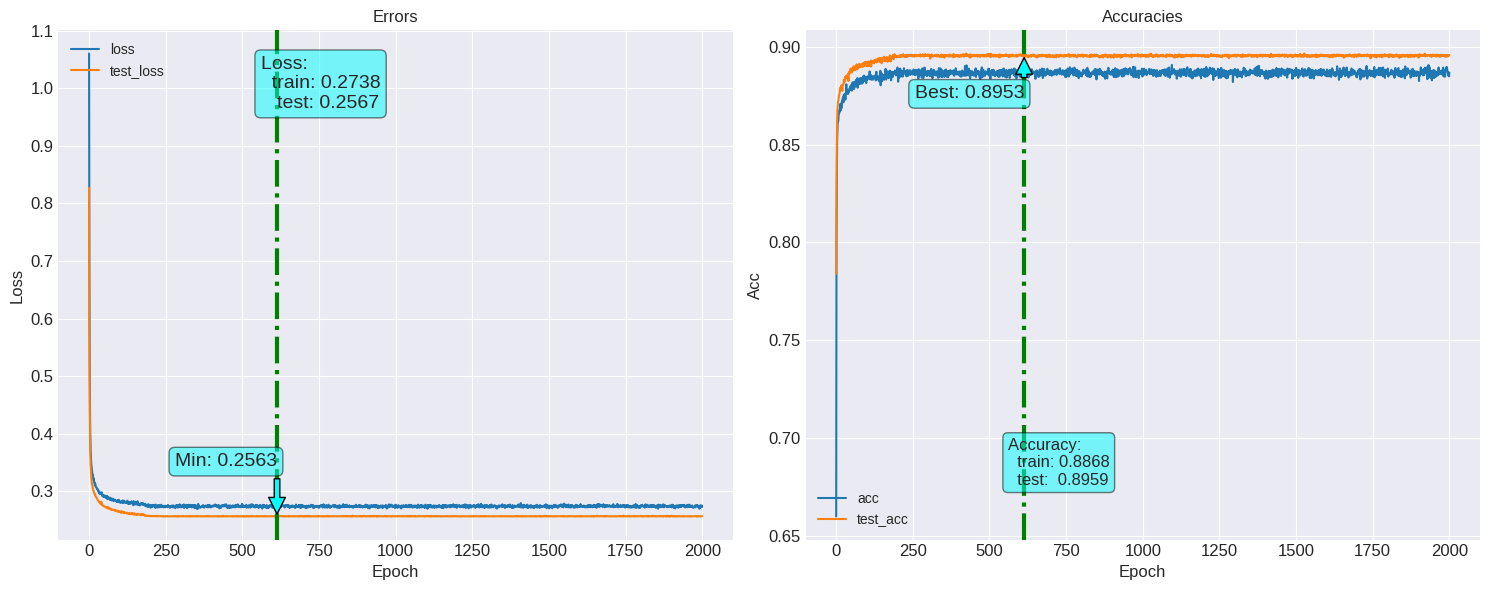

In [36]:
fn_plot_torch_hist(loss_df)

In [37]:
   outputs = model(train_X)
outputs

tensor([[-17.2901,  -0.4722,   4.8445,  -6.8768],
        [-11.1316,  -0.6068,   2.7669,  -3.5551],
        [-13.9726,   6.4218,   3.4026, -11.5731],
        ...,
        [-12.5120,   3.7296,   2.7437,  -9.2202],
        [-11.7422,   3.2969,   2.9740,  -7.6160],
        [-11.6318, -11.1790,   1.5116,   4.0112]], grad_fn=<AddmmBackward0>)

In [38]:
outputs = model(train_X)
outputs.shape    #Tensor

torch.Size([256, 4])

In [39]:
outputs = model(train_X)    #same as above because device was not showing device='cuda:0'
outputs.cpu()               #here we are converting it to cpu

tensor([[-17.2901,  -0.4722,   4.8445,  -6.8768],
        [-11.1316,  -0.6068,   2.7669,  -3.5551],
        [-13.9726,   6.4218,   3.4026, -11.5731],
        ...,
        [-12.5120,   3.7296,   2.7437,  -9.2202],
        [-11.7422,   3.2969,   2.9740,  -7.6160],
        [-11.6318, -11.1790,   1.5116,   4.0112]], grad_fn=<AddmmBackward0>)

In [40]:
outputs = model(train_X)    #same as above because device was not showing in the output
outputs.cpu().detach().numpy()  #.cpu() is not required

array([[-17.290129  ,  -0.4721669 ,   4.84446   ,  -6.876808  ],
       [-11.131594  ,  -0.60679597,   2.7669    ,  -3.555082  ],
       [-13.972626  ,   6.421817  ,   3.4026031 , -11.573142  ],
       ...,
       [-12.511953  ,   3.7296278 ,   2.7436557 ,  -9.220246  ],
       [-11.742207  ,   3.296936  ,   2.9739866 ,  -7.615958  ],
       [-11.631818  , -11.178984  ,   1.5115802 ,   4.0112476 ]],
      dtype=float32)

In [41]:
outputs = model(train_X)
y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
y_pred

array([2, 2, 1, 1, 0, 1, 3, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 3, 2, 2, 3, 1,
       1, 2, 2, 1, 2, 3, 3, 2, 1, 0, 2, 3, 2, 1, 2, 2, 2, 1, 3, 3, 3, 2,
       3, 2, 1, 2, 3, 3, 2, 2, 1, 3, 0, 3, 1, 2, 2, 1, 2, 3, 2, 1, 3, 2,
       1, 2, 0, 2, 2, 2, 1, 2, 2, 3, 0, 2, 2, 0, 3, 2, 2, 1, 2, 1, 2, 1,
       2, 2, 2, 3, 1, 1, 0, 2, 1, 3, 0, 2, 2, 2, 0, 1, 0, 3, 2, 2, 1, 3,
       0, 0, 3, 3, 1, 1, 2, 1, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 1, 2, 3, 1,
       3, 1, 3, 2, 3, 0, 0, 1, 1, 3, 2, 1, 2, 3, 3, 3, 2, 1, 1, 0, 2, 0,
       2, 2, 0, 3, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2,
       1, 0, 2, 1, 3, 2, 3, 1, 1, 3, 1, 3, 0, 2, 0, 2, 1, 2, 3, 2, 1, 1,
       1, 3, 2, 2, 1, 1, 3, 1, 2, 2, 2, 1, 2, 2, 3, 3, 2, 2, 2, 1, 3, 1,
       0, 1, 1, 2, 1, 1, 1, 2, 3, 0, 3, 0, 2, 2, 3, 1, 0, 1, 2, 1, 3, 2,
       1, 1, 2, 3, 3, 2, 3, 2, 1, 2, 1, 1, 1, 3])

In [42]:
y_train

array([1, 2, 1, ..., 0, 0, 0], dtype=int8)

In [43]:
print(classification_report(train_y.cpu().numpy(), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.88      0.96      0.92        71
           2       0.85      0.85      0.85       102
           3       0.89      0.80      0.84        59

    accuracy                           0.88       256
   macro avg       0.91      0.90      0.90       256
weighted avg       0.88      0.88      0.88       256



In [44]:
y_true = train_y.cpu().numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.88      0.96      0.92        71
           2       0.85      0.85      0.85       102
           3       0.89      0.80      0.84        59

    accuracy                           0.88       256
   macro avg       0.91      0.90      0.90       256
weighted avg       0.88      0.88      0.88       256



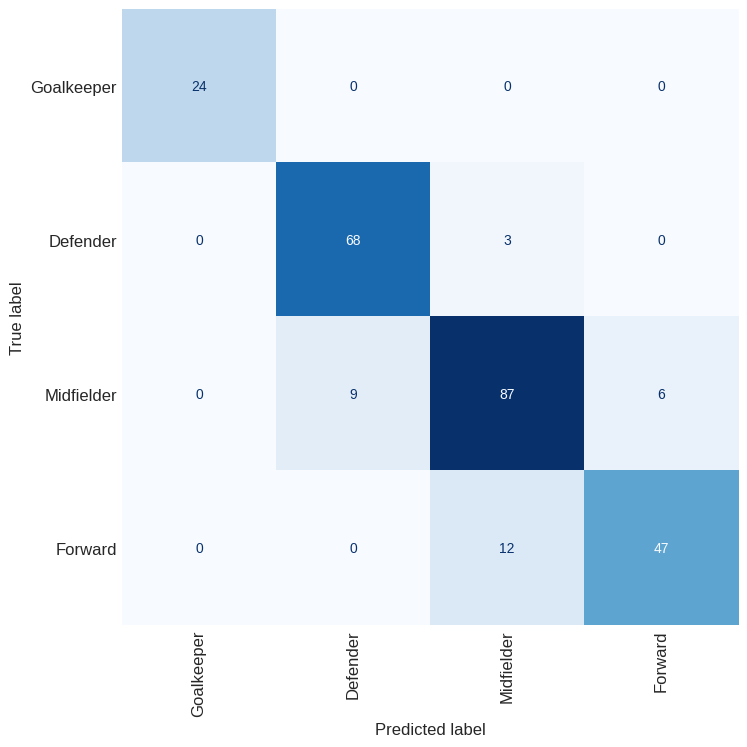

In [45]:
cm= confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels.values())
disp.plot(cmap='Blues', xticks_rotation='vertical', colorbar=False)
plt.grid(False)
plt.show()



In [46]:
''' Define custom dataset'''
class FifaDataset(Dataset):
  def __init__(self, X, y):
    super(FifaDataset,self).__init__()
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.long)
  def __len__(self):
    return(len(self.X))
  def __getitem__(self, idx):
    return(self.X[idx], self.y[idx])

In [47]:
train_dataset = FifaDataset(X_train, y_train)

train_loader = DataLoader(dataset=train_dataset,
                          shuffle=True,
                          batch_size=BATCH_SIZE, )

X_batch, y_batch = next(iter(train_loader))
X_batch.shape, y_batch.shape


(torch.Size([256, 33]), torch.Size([256]))

In [48]:
test_dataset = FifaDataset(X_train, y_train)

test_loader = DataLoader(dataset=train_dataset,
                          shuffle=True,
                          batch_size=BATCH_SIZE, )

X_batch, y_batch = next(iter(train_loader))
X_batch.shape, y_batch.shape


(torch.Size([256, 33]), torch.Size([256]))